In [1]:
# Change the dataset in global_vars.py to NAKO.
from global_vars import *
from commons import *

import glob 
import os

one_time_n4_optimization = True
vol_to_check_list = None #['100025']
exclude = ['100006']  # No SPleen

%load_ext autoreload
%autoreload 2

In [2]:
def load_nako_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
        opp_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_opp/**.nii.gz') # **_2**
        in_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_in/**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_F/**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/{vol}_3D_GRE_TRA_W/**.nii.gz')
        
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths

file_paths = load_nako_file_paths()
file_paths

{'100094': {'VOLUME_PATHS': {'OPP': ['/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_1.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_2.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_3.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_opp/3D_GRE_TRA_opp_3D_GRE_TRA_4.nii.gz'],
   'IN': ['/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_1_e2.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_2_e2.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_3_e2.nii.gz',
    '/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI/100094/100094_3D_GRE_TRA_in/3D_GRE_TRA_in_3D_GRE_TRA_4_e2.nii.gz'],
   'F': ['/mnt/nas/Data_WholeBody/NAKO/NAKO_200/MRI

In [3]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [4]:
# SITK does ot work due to differences in pixel resolution of IN and corresponding OPP Scan.
# Only applying once at the end.
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    for idx, n4_d in enumerate(n4_dict[vol]):
        in_file = n4_d['SCALED']
        opp_file = file_paths[vol]['VOLUME_PATHS']['OPP'][idx]
        new_filename = opp_file.split('/')[-1].split('.')[0]
        output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
        SITK_N4_normalization(in_file, opp_file, output_file)
        n4_dict[vol][idx]['OPP_CORRECTED'] = output_file

    file_paths[vol]['N4_1'] = n4_dict[vol]

In [5]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    print(f'started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'

started with 100094...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -395.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -587.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -815.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.406

Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.40625000e+00  0.00000000e+00  0.00000000e+00 -2.11993027e+02]
 [ 0.00000000e+00  1.40625000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.07803955e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp2/NAKO/n4_corrected_2/vol/100025
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -211.99302673]
 [   0.            1.40625       0.         -178.90625   ]
 [   0.            0.            3.         -418.03955078]
 [   0.            0.            0.            1.        ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         

Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -617.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -845.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.4062500e+00  0.0000000e+00  0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  1.4062500e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0850000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
0

processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -226.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -405.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -226.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -597.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -226.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -825.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.4062500e+00  0.0000000e+00 

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp2/NAKO/n4_corrected_2/vol/100183
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -233.59375]
 [   0.         1.40625    0.      -191.40625]
 [   0.         0.         3.      -370.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -233.59375]
 [   0.         1.40625    0.      -191.40625]
 [   0.         0.         3.      -562.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -233.59375]
 [   0.         1.40625    0.      -191.40625]
 [   0.         0.         3.      -790.     ]
 [   0.         0.         0.  

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp2/NAKO/n4_corrected_2/vol/100085
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -452.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -644.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -872.5    ]
 [   0.         0.         0. 

Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         -248.89984131]
 [   0.            1.40625       0.         -178.90625   ]
 [   0.            0.            3.         -852.23028564]
 [   0.            0.            0.            1.        ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.40625000e+00  0.00000000e+00  0.00000000e+00 -2.48899841e+02]
 [ 0.00000000e+00  1.40625000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.09223022e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp2/NAKO/n4_corrected_2/vol/100181
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625       0.            0.         

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp2/NAKO/n4_corrected_2/vol/100142
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -233.59375]
 [   0.         1.40625    0.      -166.40625]
 [   0.         0.         3.      -422.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -233.59375]
 [   0.         1.40625    0.      -166.40625]
 [   0.         0.         3.      -614.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -233.59375]
 [   0.         1.40625    0.      -166.40625]
 [   0.         0.         3.      -842.5    ]
 [   0.         0.         0. 

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp2/NAKO/n4_corrected_2/vol/100017
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -472.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -664.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -216.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -892.5    ]
 [   0.         0.         0.  

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp2/NAKO/n4_corrected_2/vol/100116
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -415.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -607.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -835.     ]
 [   0.         0.         0. 

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
2th img for stitching...
saving directory: temp2/NAKO/n4_corrected_2/vol/100020
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -442.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -634.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -223.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -862.5    ]
 [   0.         0.         0.  

Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -592.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -221.09375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -820.     ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.4062500e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  1.4062500e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0600000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
0

processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -238.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -437.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -238.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -629.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 96)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   1.40625    0.         0.      -238.59375]
 [   0.         1.40625    0.      -178.90625]
 [   0.         0.         3.      -857.5    ]
 [   0.         0.         0.         1.     ]], Image Shape: (320, 260, 88)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[ 1.4062500e+00  0.0000000e+00  

In [6]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

n4 processing part-2 started with 100094...
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0550000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
-122.0
neagtive value detected
saving directory: temp2/NAKO/n4_corrected_2/vol/100094
n4 processing part-2 started with 100025...
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.11993027e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.07803955e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
-116.0
neagtive value detected
saving directory: temp2/NAKO/n4_corrected_2/vol

Transforming Images to RAS.....
-144.0
neagtive value detected
saving directory: temp2/NAKO/n4_corrected_2/vol/100083
n4 processing part-2 started with 100097...
Reading Files.....
Reading Nifti Files.....
Affine:[[ 2.0000000e+00  0.0000000e+00  0.0000000e+00 -2.3859375e+02]
 [ 0.0000000e+00  2.0000000e+00  0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0975000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)
Transforming Images to RAS.....
-111.0
neagtive value detected
saving directory: temp2/NAKO/n4_corrected_2/vol/100097


In [8]:
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    in_file = n4_dict[vol]['N4_2']['SCALED']
    opp_file = file_paths[vol]['ONE']['OPP']
    new_filename = opp_file.split('/')[-1].split('.')[0]
    output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
    SITK_N4_normalization(in_file, opp_file, output_file)
    n4_dict[vol]['N4_2']['OPP_CORRECTED'] = output_file
    file_paths[vol]['N4_2'] = n4_dict[vol]['N4_2']

n4-biasfield-correction starting with 100094...
done
n4-biasfield-correction starting with 100025...
done
n4-biasfield-correction starting with 100129...
done
n4-biasfield-correction starting with 100013...
done
n4-biasfield-correction starting with 100161...
done
n4-biasfield-correction starting with 100183...
done
n4-biasfield-correction starting with 100035...
done
n4-biasfield-correction starting with 100085...
done
n4-biasfield-correction starting with 100181...
done
n4-biasfield-correction starting with 100112...
done
n4-biasfield-correction starting with 100142...
done
n4-biasfield-correction starting with 100017...
done
n4-biasfield-correction starting with 100009...
done
n4-biasfield-correction starting with 100116...
done
n4-biasfield-correction starting with 100020...
done
n4-biasfield-correction starting with 100008...
done
n4-biasfield-correction starting with 100083...
done
n4-biasfield-correction starting with 100097...
done


In [9]:
def nako_vol_label_fix(vol, label):
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    final_label = np.zeros(tuple(world_shape))

    label_affine = label.affine
    vol_affine = vol.affine
    
    target_affine = vol_affine
    target_header = vol.header
    target_dim_v = vol.shape

    sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))
    
    final_label[0:ex+sx, 0:ey+sy, sz:ez] = label.get_fdata()
    
    final_label = np.flip(final_label, axis=0)
    final_label = np.flip(final_label, axis=1)
    
    final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
    return vol, final_label_img

def nako_label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = get_freequent_shape([img.shape for img, _, _ in label_parts])
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape

    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print(lidx, lname)
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        sx,sy,sz,ex,ey,ez = np.abs(get_points(labelmap_img, reference_labelmap))
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
100094
['datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Spleen.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100094/100094_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100094/100094_3D_G

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100094/100094_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100094/100094_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100094/100094_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
SPL DATASETS/LABLMAPS/NAKO/100094/100094_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100094/100094_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100094/100094_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100094/100094_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100094/100094_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
[False, False, False, False] False
KIDNEY_L DATASETS/LABLMAPS/NAKO/100094/100094_3D_GRE_TRA_OPP_3D_GRE_

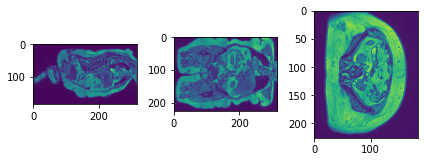

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0550000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


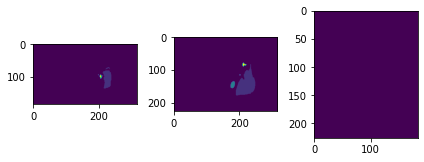

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100025
['datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver-2.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right) .nrrd', 'datasets/lablmaps/NAKO/100025/100025_3D_GRE_TRA_opp_

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100025/100025_3D_GRE_TRA_OPP_3D_GRE_TRA_1.NRRD_THYROIDGLAND.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100025/100025_3D_GRE_TRA_OPP_3D_GRE_TRA_1.NRRD_THYROIDGLAND.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100025/100025_3D_GRE_TRA_OPP_3D_GRE_TRA_1.NRRD_THYROIDGLAND.NRRD
SPL DATASETS/LABLMAPS/NAKO/100025/100025_3D_GRE_TRA_OPP_3D_GRE_TRA_1.NRRD_THYROIDGLAND.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100025/100025_3D_GRE_TRA_OPP_3D_GRE_TRA_1.NRRD_THYROIDGLAND.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100025/100025_3D_GRE_TRA_OPP_3D_GRE_TRA_1.NRRD_THYROIDGLAND.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100025/100025_3D_GRE_TRA_OPP_3D_GRE_TRA_1.NRRD_THYROIDGLAND.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100025/100025_3D_GRE_TRA_OPP_3D_GRE_TRA_1.NRRD_THYROIDGLAND.NRRD
[False, False, False, False] False
KIDNEY_L DATASETS/LABLMAPS/NAKO/100025/100025_3D_GRE

105 ADRENAL(RIGHT)
###############################################################################################
107 PANCREAS
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
101 LIVER
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
108 GALLBLADDER
###############################################################################################
102 SPLEEN
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (226, 184, 316)
segm dim v:  (226, 184, 96)
im spaci

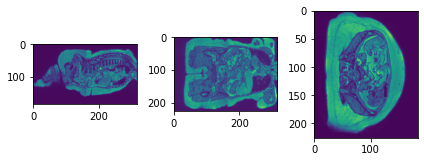

Affine:[[ 2.00000000e+00  0.00000000e+00 -0.00000000e+00 -2.11993027e+02]
 [ 0.00000000e+00  2.00000000e+00 -0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.07803955e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)


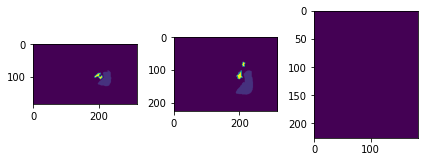

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100129
['datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Spleen.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Liver.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Kidney (right)-2.nrrd', 'datasets/lablmaps/NAKO/100129/100129_3D_GRE_TRA_opp_3D_GRE_TRA_2-5_Adrenal gland(left).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100129/100129_3D_GRE_TRA_OPP_3D_GRE_T

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100129/100129_3D_GRE_TRA_OPP_3D_GRE_TRA_2-5_KIDNEY(RIGHT)-2.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100129/100129_3D_GRE_TRA_OPP_3D_GRE_TRA_2-5_KIDNEY(RIGHT)-2.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100129/100129_3D_GRE_TRA_OPP_3D_GRE_TRA_2-5_KIDNEY(RIGHT)-2.NRRD
SPL DATASETS/LABLMAPS/NAKO/100129/100129_3D_GRE_TRA_OPP_3D_GRE_TRA_2-5_KIDNEY(RIGHT)-2.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100129/100129_3D_GRE_TRA_OPP_3D_GRE_TRA_2-5_KIDNEY(RIGHT)-2.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100129/100129_3D_GRE_TRA_OPP_3D_GRE_TRA_2-5_KIDNEY(RIGHT)-2.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100129/100129_3D_GRE_TRA_OPP_3D_GRE_TRA_2-5_KIDNEY(RIGHT)-2.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100129/100129_3D_GRE_TRA_OPP_3D_GRE_TRA_2-5_KIDNEY(RIGHT)-2.NRRD
[False, True, False, False] True
Reading Files.....
Reading NRRD Files.....
Transformin

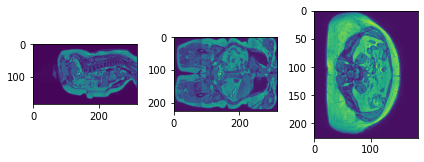

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0850000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


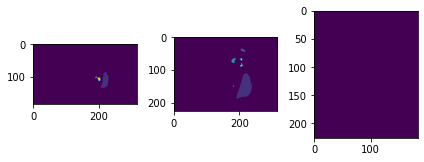

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100013
['datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2-3_subcutan_fat.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100013/100113_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_2_spleen.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GTE_TRA_opp_2_nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GR_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100013/100013_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pa

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100013/100013_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100013/100013_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100013/100013_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER.NRRD
SPL DATASETS/LABLMAPS/NAKO/100013/100013_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100013/100013_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100013/100013_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100013/100013_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100013/100013_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER.NRRD
[False, False, False, False] False
KIDNEY_L DATASETS/LABLMAPS/NAKO/100013/100013_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER.NRRD
KIDNEY(LE

105 ADRENAL(RIGHT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
108 GALLBLADDER
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
101 LIVER
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
107 PANCREAS
###############################################################################################
102 SPLEEN
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (226, 184, 316)
segm dim v:  (226, 184, 96)
im spaci

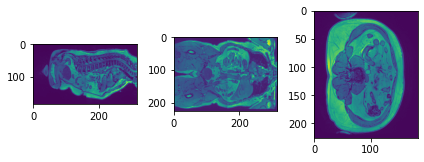

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0850000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


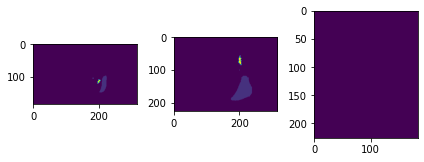

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100161
['datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Spleen.nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100161/100161_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Pancreas.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100161/100161_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_KIDNEY(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100161/10

103 KIDNEY(RIGHT)
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
101 LIVER
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
107 PANCREAS
###############################################################################################
102 SPLEEN
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (226, 184, 316)
segm dim v:  (226, 184, 96)
im spacing:  [2. 2. 3.]
segm spacing:  [2. 2. 3.]
im dim w:  [452. 368. 948.]
segm dim w:  [452. 368. 288.]
im off:  [  

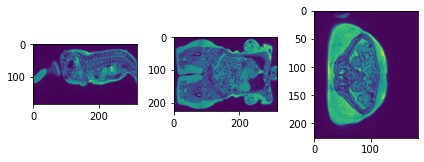

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2609375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


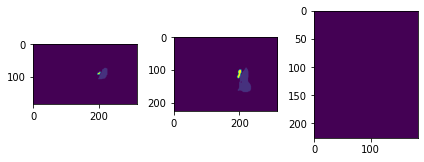

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100183
['datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Liver-2.nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100183/100183_3D_GRE_TRA_opp_3D_GRE_TRA_2-14_Spleen.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100183/100183_3D_GRE_TRA_OPP_3D_GRE_TRA_2-14_LIVER-2.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100183/100183_3D

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100183/100183_3D_GRE_TRA_OPP_3D_GRE_TRA_2-14_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100183/100183_3D_GRE_TRA_OPP_3D_GRE_TRA_2-14_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100183/100183_3D_GRE_TRA_OPP_3D_GRE_TRA_2-14_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/NAKO/100183/100183_3D_GRE_TRA_OPP_3D_GRE_TRA_2-14_SPLEEN.NRRD
[True, True] True
101 LIVER
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
106 ADRENAL(LEFT)
#################################################################

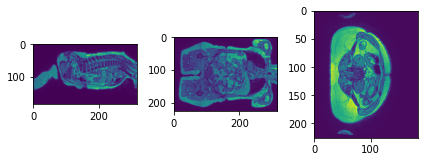

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.3359375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.9140625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0300000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


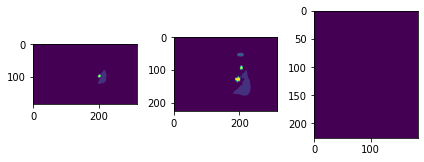

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100035
['datasets/lablmaps/NAKO/100035/35_spl.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_2_nii_Liver.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100035/100035_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd']
Reading 

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100035/100035_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100035/100035_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100035/100035_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(LEFT).NRRD
SPL DATASETS/LABLMAPS/NAKO/100035/100035_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100035/100035_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100035/100035_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100035/100035_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(LEFT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100035/100035_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(LEFT).NRRD
[False, False, False, False] False
KIDNEY_L DATASETS/LABLMAPS/NAKO/100035/100035_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(LEFT).NRRD


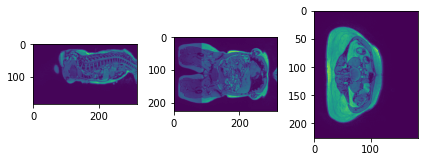

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.3609375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0625000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


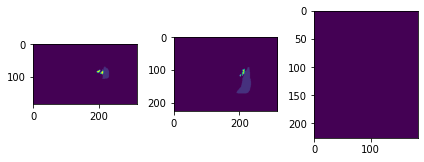

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100085
['datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(left).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver-2-2.nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100085/100085_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100085/100085_3D_GRE_TRA_OPP_3D_GRE_TRA_2_

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100085/100085_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NRRD_GALLBLADDER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100085/100085_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NRRD_GALLBLADDER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100085/100085_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NRRD_GALLBLADDER.NRRD
SPL DATASETS/LABLMAPS/NAKO/100085/100085_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NRRD_GALLBLADDER.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100085/100085_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NRRD_GALLBLADDER.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100085/100085_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NRRD_GALLBLADDER.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100085/100085_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NRRD_GALLBLADDER.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100085/100085_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NRRD_GALLBLADDER.NRRD
[False, False, False, False] False
KIDNEY_L DATASETS/LABLMAPS/NAKO/100085/100085_3D_GRE_TRA_OPP

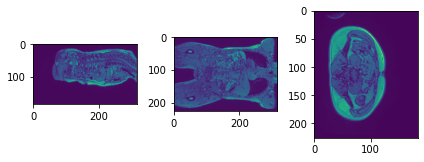

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1125000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


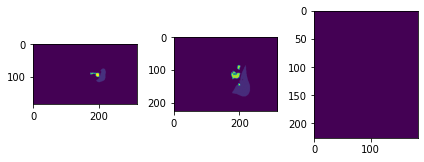

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100181
['datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Spleen-2.nrrd', 'datasets/lablmaps/NAKO/100181/100181_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Liver-4.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100181/100181_3D_GRE_TRA_OPP_3D_GRE_TRA_2

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100181/100181_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_KIDNEY(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100181/100181_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_KIDNEY(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100181/100181_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_KIDNEY(RIGHT).NRRD
SPL DATASETS/LABLMAPS/NAKO/100181/100181_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_KIDNEY(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100181/100181_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100181/100181_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100181/100181_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_KIDNEY(RIGHT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100181/100181_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_KIDNEY(RIGHT).NRRD
[False, True, True, False] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS..

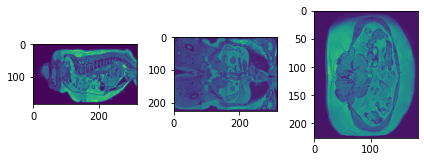

Affine:[[ 2.00000000e+00  0.00000000e+00 -0.00000000e+00 -2.48899841e+02]
 [ 0.00000000e+00  2.00000000e+00 -0.00000000e+00 -1.78906250e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.09223022e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)


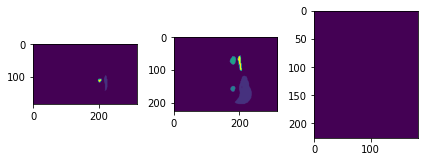

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100112
['datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100112/100112_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Liver.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100112/100112_3D_G

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2_SPLEEN.NRRD
[True, True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2-2.NRRD_ADRENALGLAND(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2-2.NRRD_ADRENALGLAND(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2-2.NRRD_ADRENALGLAND(LEFT).NRRD
SPL DATASETS/LABLMAPS/NAKO/100112/100112_3D_GRE_TRA_OPP_3D_GRE_TRA_2-2.NRRD_ADRENALGLAND(LEFT).NRRD
[False, False] False
KIDNEY_

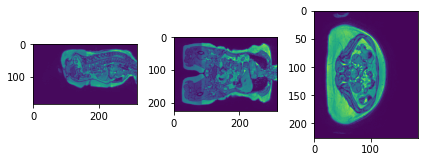

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0650000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


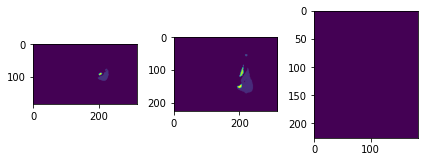

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100142
['datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_ADRENALGLAND(LEFT).NRRD
[False]

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_LIVER.NRRD
[True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
SPL DATASETS/LABLMAPS/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100142/100142_3D_GRE_TRA_W_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100142/100142_3D_GRE_TRA_

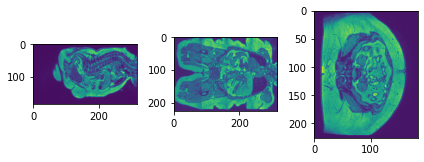

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.3359375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.6640625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0825000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


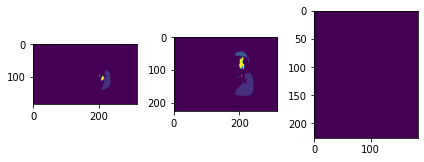

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100017
['datasets/lablmaps/NAKO/100017/100017 _3D_GRE_TRA_opp_3D_GRE_TRA_2_subcutaneous.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_2_nii_Spleen.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas-2.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GTE_TRA_opp_2_nii_Liver-2-3.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nii_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100017/100017_3D_GRE_TRA_opp_3D_GRE_TRA_2_

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100017/100017_3D_GTE_TRA_OPP_2_NII_LIVER-2-3.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100017/100017_3D_GTE_TRA_OPP_2_NII_LIVER-2-3.NRRD
[True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100017/100017_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100017/100017_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100017/100017_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
SPL DATASETS/LABLMAPS/NAKO/100017/100017_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100017/100017_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100017/100017_3D_GRE_TRA_OPP_3D_GRE_TRA_2.NII_GALLBLADDER.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100

im dim v:  (226, 184, 316)
segm dim v:  (226, 184, 96)
im spacing:  [2. 2. 3.]
segm spacing:  [2. 2. 3.]
im dim w:  [452. 368. 948.]
segm dim w:  [452. 368. 288.]
im off:  [  216.09375   178.90625 -1132.5    ]
segm off:  [ 232.5     185.3125 -664.5   ]
im start:  [  216.09375   178.90625 -1132.5    ]
im end:  [-235.90625 -189.09375 -184.5    ]
segm start:  [ 232.5     185.3125 -664.5   ]
segm end:  [-219.5    -182.6875 -376.5   ]
start diff w:  [ 16.40625   6.40625 468.     ]
end_diff w  [ 16.40625   6.40625 192.     ]
start diff v:  [  8   3 156]
end diff v:  [ 8  3 64]
segm end v:  [218 181 252]
segm start v:  -8 -3 156
Viewing Stitched Images.....
Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.1609375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1325000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


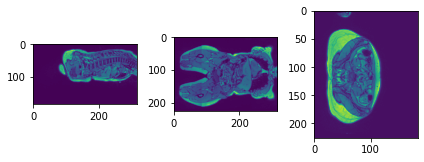

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.1609375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1325000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


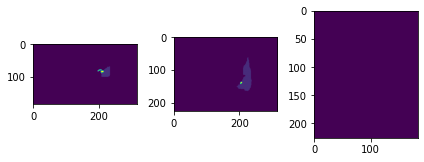

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100009
['datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100009/100009_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100009/100009_3D_GRE_TRA_OPP_3D_GRE_TRA_KIDNEY(LEFT).NR

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100009/100009_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100009/100009_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100009/100009_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
SPL DATASETS/LABLMAPS/NAKO/100009/100009_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100009/100009_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100009/100009_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100009/100009_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100009/100009_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(RIGHT).NRRD
[False, True, True, False] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND D

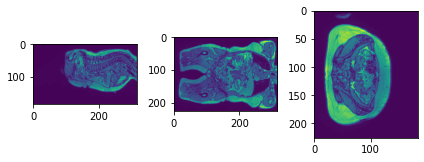

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.3859375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1050000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


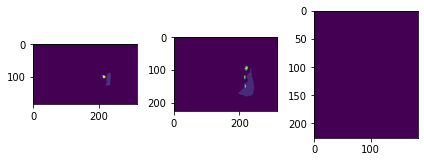

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100116
['datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Spleen.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Liver.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100116/100116_3D_GRE_TRA_opp_3D_GRE_TRA_2-4_Adrenal gland(right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100116/100116_3D_GRE_TRA_OPP_3D_GRE_TRA

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100116/100116_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100116/100116_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_LIVER.NRRD
[True] True
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100116/100116_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_PANCREAS.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100116/100116_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_PANCREAS.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100116/100116_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_PANCREAS.NRRD
SPL DATASETS/LABLMAPS/NAKO/100116/100116_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_PANCREAS.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100116/100116_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_PANCREAS.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100116/100116_3D_GRE_TRA_OPP_3D_GRE_TRA_2-4_PANCREAS.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100116/100116_3D_GRE_TR

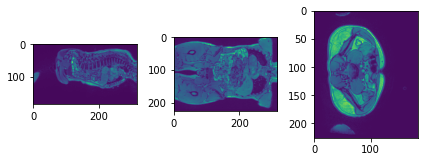

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0750000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


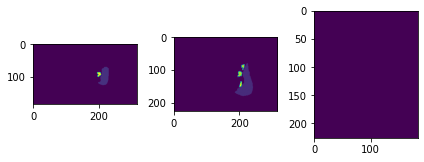

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100020
['datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder (1).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100020/10020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_TRA_opp_3D_GRE_TRA_1.nrrd_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100020/100020_3D_GRE_T

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100020/100020_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER(1).NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100020/100020_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER(1).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100020/100020_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER(1).NRRD
SPL DATASETS/LABLMAPS/NAKO/100020/100020_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER(1).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100020/100020_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER(1).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100020/100020_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER(1).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100020/100020_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER(1).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100020/100020_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GALLBLADDER(1).NRRD
[False, False, False, False] False
KIDNEY_L DATASETS/LABLMAPS/NAKO/100020/100020_3D_GRE_TRA_OPP_3D_GRE_TRA_2_GA

107 PANCREAS
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
108 GALLBLADDER
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
101 LIVER
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
102 SPLEEN
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
im dim v:  (226, 184, 316)
segm dim v:  (226, 184, 96)
im spaci

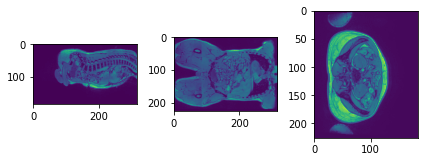

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2359375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.1025000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


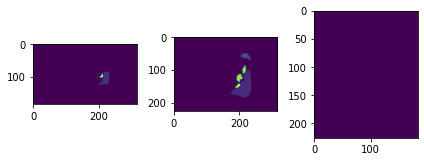

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100008
['datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (left).nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2-2.nrrd_Spleen-5.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder (1).nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland (right).nrrd', 'datasets/lablmaps/NAKO/100008/10008_3D_GRE_TRA_opp_3D_GRE_TRA_2.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney (right) (1).nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_1_Thyroid gland.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(left)-4.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas-3.nrrd', 'datasets/lablmaps/NAKO/100008/100008_3D_GRE

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100008/100008_3D_GRE_TRA_OPP_3D_GRE_TRA_1_THYROIDGLAND.NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100008/100008_3D_GRE_TRA_OPP_3D_GRE_TRA_1_THYROIDGLAND.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100008/100008_3D_GRE_TRA_OPP_3D_GRE_TRA_1_THYROIDGLAND.NRRD
SPL DATASETS/LABLMAPS/NAKO/100008/100008_3D_GRE_TRA_OPP_3D_GRE_TRA_1_THYROIDGLAND.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100008/100008_3D_GRE_TRA_OPP_3D_GRE_TRA_1_THYROIDGLAND.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100008/100008_3D_GRE_TRA_OPP_3D_GRE_TRA_1_THYROIDGLAND.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100008/100008_3D_GRE_TRA_OPP_3D_GRE_TRA_1_THYROIDGLAND.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100008/100008_3D_GRE_TRA_OPP_3D_GRE_TRA_1_THYROIDGLAND.NRRD
[False, False, False, False] False
KIDNEY_L DATASETS/LABLMAPS/NAKO/100008/100008_3D_GRE_TRA_OPP_3D_GRE_TRA_1_THYROIDGLAND.NRRD


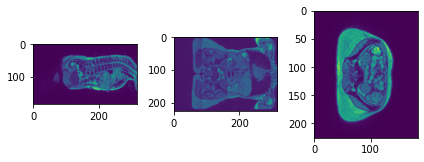

Affine:[[ 2.00000000e+00  0.00000000e+00 -0.00000000e+00 -2.31093750e+02]
 [ 0.00000000e+00  2.00000000e+00 -0.00000000e+00 -2.14435913e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.04476697e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (226, 184, 316)


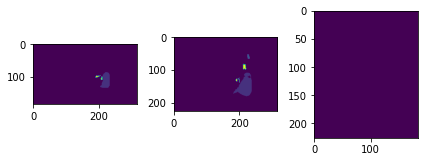

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100083
['datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(left).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Kidney(right).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Liver.nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Gallbladder.nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100083/100083_3D_GRE_TRA_opp_3D_GRE_TRA_2_Spleen.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100083/100083_3D_GRE_TRA_OPP_3D_GRE_TRA_2_KIDNEY(LEFT).NR

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100083/100083_3D_GRE_TRA_OPP_3D_GRE_TRA_2_ADRENALGLAND(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100083/100083_3D_GRE_TRA_OPP_3D_GRE_TRA_2_ADRENALGLAND(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100083/100083_3D_GRE_TRA_OPP_3D_GRE_TRA_2_ADRENALGLAND(RIGHT).NRRD
SPL DATASETS/LABLMAPS/NAKO/100083/100083_3D_GRE_TRA_OPP_3D_GRE_TRA_2_ADRENALGLAND(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100083/100083_3D_GRE_TRA_OPP_3D_GRE_TRA_2_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100083/100083_3D_GRE_TRA_OPP_3D_GRE_TRA_2_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100083/100083_3D_GRE_TRA_OPP_3D_GRE_TRA_2_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100083/100083_3D_GRE_TRA_OPP_3D_GRE_TRA_2_ADRENALGLAND(RIGHT).NRRD
[False, False, False, False] False
KIDNEY_L DATASETS/LABLMAPS/NAKO/1000

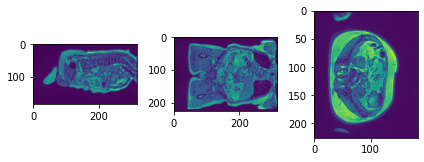

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.2109375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0600000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


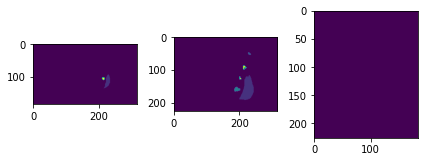

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.
100097
['datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Kidney (right).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Spleen.nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Liver.nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Pancreas.nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Kidney (left).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Adrenal gland(left).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Adrenal gland(right).nrrd', 'datasets/lablmaps/NAKO/100097/100097_3D_GRE_TRA_opp_3D_GRE_TRA_2-15_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100097/100097_3D_GRE_TRA_OPP_3D

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/NAKO/100097/100097_3D_GRE_TRA_OPP_3D_GRE_TRA_2-15_ADRENALGLAND(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/NAKO/100097/100097_3D_GRE_TRA_OPP_3D_GRE_TRA_2-15_ADRENALGLAND(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/NAKO/100097/100097_3D_GRE_TRA_OPP_3D_GRE_TRA_2-15_ADRENALGLAND(RIGHT).NRRD
SPL DATASETS/LABLMAPS/NAKO/100097/100097_3D_GRE_TRA_OPP_3D_GRE_TRA_2-15_ADRENALGLAND(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/NAKO/100097/100097_3D_GRE_TRA_OPP_3D_GRE_TRA_2-15_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/NAKO/100097/100097_3D_GRE_TRA_OPP_3D_GRE_TRA_2-15_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/NAKO/100097/100097_3D_GRE_TRA_OPP_3D_GRE_TRA_2-15_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/NAKO/100097/100097_3D_GRE_TRA_OPP_3D_GRE_TRA_2-15_ADRENALGLAND(RIGHT).NRRD
[False, False, False, False] False
KIDNEY_L DAT

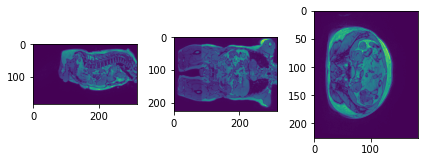

Affine:[[ 2.0000000e+00  0.0000000e+00 -0.0000000e+00 -2.3859375e+02]
 [ 0.0000000e+00  2.0000000e+00 -0.0000000e+00 -1.7890625e+02]
 [ 0.0000000e+00  0.0000000e+00  3.0000000e+00 -1.0975000e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]], Image Shape: (226, 184, 316)


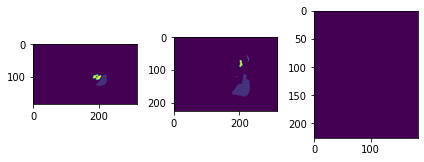

Saving Processed & Stitched Image.....
saving directory: temp2/NAKO/processed/volume
saving directory: temp2/NAKO/processed/label
FINISHED.


In [10]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    later = []
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
#     volume = nb.load(file_paths[vol]['ONE']['OPP'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if labelname is None or img_ras is None:
            continue
        img_ras = makeit_3d(img_ras)
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=0, mode='constant', cval=0)
        if labelname == 'SPLEEN':
            later.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
        else:
            img_ras_list.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
    
    img_ras_list.extend(later)
    
    s_label = nako_label_parts(img_ras_list)
    s_label = drop_overlapped_pixels(s_label, np.array(img_ras_list)[:, 1])
    volume, s_label = nako_vol_label_fix(volume, s_label)

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))
    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    print('FINISHED.')